## NLP
## Lab 3 - Levenshtein distance and spelling corrections

In [140]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import os
from collections import Counter
import Levenshtein
import numpy as np
import time
import re

#### Zadanie 1.
Inicjalizacja tokenizera dla języka polskiego i wczytanie ustaw.

In [23]:
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)

In [24]:
all_files = []
path = './ustawy'
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
        all_files.append(" ".join(file.read().lower().replace('\n', ' ').split()))

#### Zadania 2., 3. i 4.
Użyta funkcja *isalpha* zwraca wartość *True* również dla polskich liter ze znakami diakrytycznymi. 

In [25]:
global_frequency_list = {}
for file in all_files:
    tokens = tokenizer(file)
    words = [token.text for token in tokens if len(token.text) >= 2 and all(char.isalpha() for char in token.text)]
    word_counter = Counter(words)
    for word, count in word_counter.items():
        if word in global_frequency_list:
            global_frequency_list[word] += count
        else:
            global_frequency_list[word] = 1

#### Zadanie 5.
W celu przygotowania wykresu dane zostały posortowane według ilości wystąpień, a następnie alfabetycznie jeśli ilość była taka sama.

In [33]:
frequency_list_ordered = {k: v for k, v in sorted(global_frequency_list.items(), key=lambda item: (item[1]*-1, item[0]))}

In [59]:
def get_entries_range(dictionary, start, end):
    return {k: dictionary[k] for k in list(dictionary)[start:end]}

Poniżej wyświetlone zostały przykładowe fragmenty posortowanych danych.

In [60]:
get_entries_range(frequency_list_ordered, 0, 10)

{'do': 60341,
 'na': 50368,
 'lub': 45594,
 'nr': 45105,
 'się': 44074,
 'oraz': 33156,
 'mowa': 28849,
 'nie': 22945,
 'przez': 20822,
 'pkt': 19091}

In [61]:
get_entries_range(frequency_list_ordered, 700, 715)

{'działalnością': 498,
 'powodu': 498,
 'zostać': 498,
 'przekazywania': 495,
 'dotacji': 494,
 'leczniczych': 494,
 'urlopu': 494,
 'właściwych': 494,
 'jakie': 493,
 'właściwej': 493,
 'jednostkę': 492,
 'mających': 492,
 'stopień': 492,
 'ue': 492,
 'zastosowania': 492}

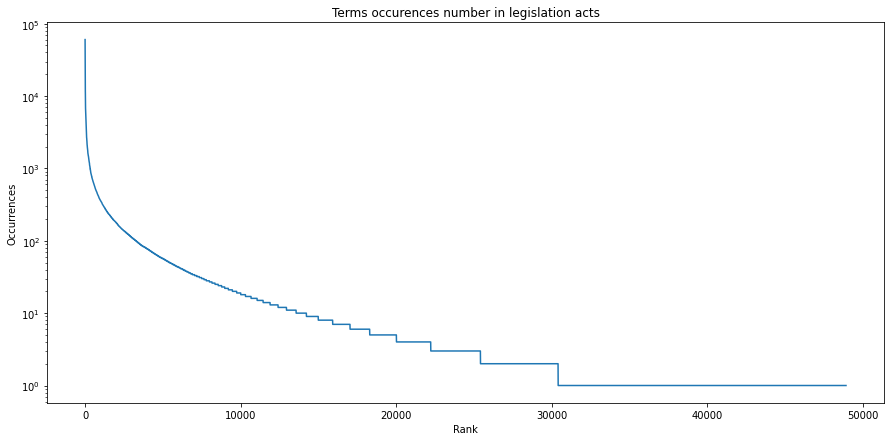

In [37]:
plt.figure(figsize=(15, 7))
plt.yscale('log')
plt.ylabel('Occurrences')
plt.xlabel('Rank')
plt.title('Terms occurences number in legislation acts')
plt.plot([rank for rank in range(len(frequency_list_ordered))], frequency_list_ordered.values())
plt.show()

#### Zadanie 6.

In [38]:
dict_words = set()
with open("./polimorfologik-2.1/polimorfologik-2.1.txt", 'r', encoding="utf-8") as polimorfologik:
    for line in polimorfologik.readlines():
        dict_words.add(line.split(';')[1].lower())

In [40]:
len(dict_words)

4623718

In [56]:
words_not_in_dict = {word: count for word, count in frequency_list_ordered.items() if word not in dict_words}

#### Zadanie 7.
Poniżej wypisane zostało 30 najczęściej występujących słów spoza słownika wraz z liczbą wystąpień.

In [63]:
get_entries_range(words_not_in_dict, 0, 30)

{'gmo': 192,
 'sa': 156,
 'iv': 147,
 'ex': 97,
 'vi': 87,
 'kn': 82,
 'cn': 74,
 'uke': 73,
 'sww': 69,
 'vii': 64,
 'viii': 34,
 'ure': 29,
 'ix': 27,
 'pcn': 27,
 'udt': 27,
 'doręczeń': 25,
 'plk': 25,
 'xi': 24,
 'vitro': 22,
 'pkwiu': 21,
 'iva': 18,
 'skw': 17,
 'uokik': 17,
 'nych': 15,
 'pcb': 15,
 'ponadzakładowy': 14,
 'umorzeń': 14,
 'utk': 14,
 'iiia': 13,
 'abw': 12}

#### Zadanie 8.
Słów występujących 5 razy i niepojawiających się w słowniku było 17. Około połowa z nich to literówki.

In [165]:
words_not_in_dict_five_occurences = [word for word, count in words_not_in_dict.items() if count == 5]
words_not_in_dict_five_occurences

['aktw',
 'anonimizacji',
 'badawczorozwojowych',
 'ktrej',
 'mianowań',
 'miesiący',
 'mnożnikowymi',
 'moe',
 'naliczeń',
 'odgazowywacze',
 'operacyjnorozpoznawczych',
 'ponadzakładowa',
 'przepisw',
 'sanitarnoepidemiologicznych',
 'sposb',
 'tów',
 'ych']

#### Zadanie 9.
Do znalezienia możliwych korekt dla powyższych słów posłuży odległość Levenshteina. W funkcji poniżej wybierane są te słowa, które będą miały najmniejszą wartość odległości z całego słownika. 

In [109]:
def correct(word):
    corrections_candidates = {dict_word : Levenshtein.distance(dict_word, word) for dict_word in dict_words}
    sorted_corrections = {k: v for k, v in sorted(corrections_candidates.items(), key=lambda item: item[1])}
    min_distance = sum(get_entries_range(sorted_corrections, 0, 1).values())
    corrections = []
    for w, dist in sorted_corrections.items():
        if dist == min_distance:
            corrections.append(w)
        else:
            return corrections
    return []

In [153]:
start = time.time()
corrections = {word: correct(word) for word in words_not_in_dict_five_occurences}
end = time.time()
corrections

{'aktw': ['aktl', 'aktu', 'akty', 'akt', 'aktyw', 'aktów', 'akta'],
 'anonimizacji': ['animizacji'],
 'badawczorozwojowych': ['ogólnorozwojowych'],
 'ktrej': ['karej', 'której'],
 'mianowań': ['mianował', 'mianować', 'zmianowań'],
 'miesiący': ['miesięcy',
  'miesiąca',
  'miesiąc',
  'mieniący',
  'miesiącu',
  'mieszący',
  'miesiące'],
 'mnożnikowymi': ['nośnikowymi', 'miodnikowymi', 'mnożnikowi', 'niżnikowymi'],
 'moe': ['mon',
  'moa',
  'mo',
  'me',
  'noe',
  'moś',
  'roe',
  'mop',
  'mole',
  'moc',
  'poe',
  'joe',
  'moce',
  'moz',
  'mot',
  'może',
  'mok',
  'moń',
  'mor',
  'moje',
  'moi',
  'mod',
  'mol',
  'mob'],
 'naliczeń': ['naliczek', 'zaliczeń'],
 'odgazowywacze': ['odgazowywane', 'odparowywacze', 'odgazowywanie'],
 'operacyjnorozpoznawczych': ['nierozpoznawczych', 'przyrodoznawczych'],
 'ponadzakładowa': ['pozazakładowa'],
 'przepisw': ['przepis', 'przepisów', 'przepisu', 'przepisy', 'przepisz'],
 'sanitarnoepidemiologicznych': ['nieepidemiologicznych'],


In [154]:
time_corrections_took = end - start
time_corrections_took

132.3401699066162

Pośród znalezionych kandydatów na poprawione słowo w większości przypadków znajdują się słowa, które prawdopodobnie powinny się pojawić w ich miejsce. W tej metodzie problemem było znalezienie poprawki dla wyrazów złożonych z dwóch (np. badawczorozwojowych), dla których brakowało pauzy między nimi.

#### Zadanie 10. i 11.

In [120]:
es = Elasticsearch()
es.indices.create(
    index="legislation_acts_lab3",
    body={
        "settings": {
            "analysis": {
                "analyzer": {
                  "polish_legislation_acts_analyzer": {
                      "type": "custom",
                      "tokenizer": "standard",
                      "filter": ["morfologik_stem", "lowercase"]
                    }
                }
            }
        },
        "mappings": {
            "properties": {
                "content": {
                    "type": "text",
                    "analyzer": "polish_legislation_acts_analyzer"
                }
            }
        }
    }
)

{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'legislation_acts_lab3'}

In [121]:
path = './ustawy'
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
        es.create("legislation_acts_lab3", filename, {"content": " ".join(file.read().lower().replace('\n', ' ').split())})

In [160]:
search_result = {}
start = time.time()
for word in words_not_in_dict_five_occurences:
    search_result[word] = es.search(
        index="legislation_acts_lab3",
        body={
            "query": {
                "fuzzy": {
                  "content": {
                    "value": word,
                    "fuzziness": "AUTO",
                  }
                }
              },
            "highlight": {
                "fields" : {
                    "content" : {}
                }
            }
        }
    )['hits']['hits']
end = time.time()

In [161]:
es_corrections = {}
for word, result in search_result.items():
    highlights = [hit['highlight']['content'] for hit in result]
    es_corrections[word] = ', '.join(set([re.search('<em>.*?</em>', ' '.join(highlight)).group()[4:-5] for highlight in highlights]))

In [162]:
es_corrections

{'aktw': 'aktach, akt, aktów, akta',
 'anonimizacji': 'anonimizacja, anonimizacji',
 'badawczorozwojowych': 'badawczorozwojowymi, badawczorozwojowych',
 'ktrej': 'ktrej, ktre',
 'mianowań': 'mianowania, mianowanego, mianowani, mianowań, mianowanie, mianuje',
 'miesiący': 'miesiąca, miesiące, miesięcy, miesiąc, miesiącu',
 'mnożnikowymi': 'mnożnikowymi',
 'moe': 'moe, mocy, może',
 'naliczeń': 'naliczone, naliczonymi, naliczonych, naliczania, nalicza, naliczane',
 'odgazowywacze': 'odgazowywacze',
 'operacyjnorozpoznawczych': 'operacyjnorozpoznawczych',
 'ponadzakładowa': 'ponadzakładowej, ponadzakładowym, ponadzakładowe, ponadzakładowy, ponadzakładowa',
 'przepisw': 'przepisach, przepisów, przepisy',
 'sanitarnoepidemiologicznych': 'sanitarnoepidemiologicznych',
 'sposb': 'sposoby, sposób',
 'tów': 'łów, rowach, rów, bów, rowów, ków, owa, nów',
 'ych': 'nych, ch, wych, ych'}

In [163]:
end - start

7.21900200843811

Elasticsearch poradził sobie z zadaniem znalezienia poprawek dość dobrze, jednak np. dla słowa *ktrej* wyraz *której* nie został odnaleziony. W przypadku wyrazów złożonych z dwóch zostały one uznane za poprawne i niewymagające zmiany. Jest to lepszy wynik niż ten uzyskany przy użyciu poprzedniej metody z odległością Levenstheina.\
Zdecydowanie lepiej Elasticsearch wypada również pod względem czasu wykonania zadania (ok. 7 sekund w porównaniu do ponad 2 minut w drugiej metodzie).

#### Zadanie 12.
Na podstawie wykresu z częstotliwością występowania słów można stwierdzić, że znacznie więcej jest słów występujących rzadko.
Spośród słów, które nie znajdowały się w słowniku większość to słowa nieznane, a nie literówki. Często były to liczby rzymskie lub wyrazy złożone, które powinny zostać rozdzielone pauzą.
Obie metody znajdowania poprawek dla słów w większości przypadków dawały dobre wyniki, jednak każda z nich popełniała błędy przy różnych słowach. Żadna nie jest więc idealna, ale szybkość działania jest zdecydowanie zaletą metody wykorzystującej Elasticsearch.